In [210]:
import pandas as pd
import numpy as np
from pathlib import Path
import sys
import matplotlib.pyplot as plt
import seaborn as sns

module_path = (Path().resolve().parent/ "Modules")
sys.path.append(str(module_path))

pd.set_option("display.max_columns", None)

import my_modules, model_tuner, features # 自作モジュール

In [116]:
def preprocessing(df_to_copy):
    df = df_to_copy.copy()
    original_col = df.columns.tolist()
    df["race_id"] = df["レースID(新)"]
    df["year"] = df["日付"] // 10000
    df["month"] = df["日付"] // 100 % 100
    df["day"] = df["日付"] % 100
    df["times"] = df["開催"].str[0].astype(int)
    df["place"] = df["場所"]
    df["daily"] = df["開催"].str[2]
    df["race_num"] = df["Ｒ"]
    df["horse"] = df["馬名S"]
    df["jockey_id"] = df["騎手コード"]
    df["trainer_id"] = df["調教師コード"]
    df["horse_N"] = df["頭数"]
    df["waku_num"] = df["枠番"]
    df["horse_num"] = df["馬番"]
    df["class_code"] = df["クラスコード"]
    df["track_code"] = df["トラックコード(JV)"]
    df["corner_num"] = df["ｺｰﾅｰ"]
    df["dist"] = df["距離"].str[1:].astype(int)
    df["state"] = df["馬場状態"]
    df["weather"] = df["天気"]
    df["age_code"] = df["競走種別"]
    df["sex"] = df["性別"]
    df["age"] = df["年齢"]
    df["basis_weight"] = df["斤量"].str.replace(r'[^0-9.]', '', regex=True).astype(float)
    df["blinker"] = df["ブリンカー"]
    df["weight"] = df["馬体重"]
    df["inc_dec"] = df["馬体重増減"]
    df["weight_code"] = df["重量コード"]
    df["win_odds"] = df["単勝オッズ"]
    df["win_odds_1"] = df["指時系1・単勝"]
    df["win_odds_1_pop"] = df["指時系1・人気"]
    df["win_odds_2"] = df["指時系2・単勝"]
    df["win_odds_2_pop"] = df["指時系2・人気"]
    df["win_mul_odds_Hi"] = df["複勝オッズ上限"]
    df["win_mul_odds_Lo"] = df["複勝オッズ下限"]
    df["win_mul_odds_1_Hi"] = df["複上1"]
    df["win_mul_odds_1_Lo"] = df["指時系1・複下"]
    df["win_mul_odds_1_pop"] = df["複人気1"]
    df["win_mul_odds_2_Hi"] = df["複上2"]
    df["win_mul_odds_2_Lo"] = df["指時系2・複下"]
    df["win_mul_odds_2_pop"] = df["複人気2"]
    df["rank"] = df["確定着順"] 
    df["time_diff"] = df["着差"]
    df["time"] = df["走破タイム"]
    df["corner1_rank"] = df["1角"]
    df["corner2_rank"] = df["2角"]
    df["corner3_rank"] = df["3角"]
    df["corner4_rank"] = df["4角"]
    df["last_3F_time"] = df["上り3F"]
    df["last_3F_rank"] = df["上り3F順"]
    df["Ave_3F"]= df["Ave-3F"]
    original_col.remove("PCI")
    original_col.remove("PCI3")
    original_col.remove("RPCI")
    df["last_3F_time_diff"] = df["上3F地点差"]
    df["leg"] = df["脚質"]
    df["pop"] = df["人気"]
    df["prize"] = df["賞金"]
    df["error_code"] = df["異常コード"]
    df["father"] = df["種牡馬"]
    df["mother"] = df["母馬"]
    df["broodmare_sire"] = df["母父馬"]
    df["broodmare_sire_type"] = df["母父タイプ名"]
    df["horse_color"] = df["毛色"]
    df["id"] = df["血統登録番号"]

    df = df.drop(original_col, axis=1)

    df.info()


    return df

In [117]:
df = pd.read_csv("../Data/train_data_tmp.csv", encoding="shift-jis")
odds_df = pd.read_csv("Time_Series_Odds_win_odds.csv", encoding="shift-jis")
df.head()

,レースID(新),日付,開催,場所,Ｒ,馬名S,騎手コード,調教師コード,頭数,枠番,馬番,クラスコード,トラックコード(JV),ｺｰﾅｰ,距離,馬場状態,天気,競走種別,性別,年齢,斤量,ブリンカー,馬体重,馬体重増減,重量コード,単勝オッズ,指時系1・単勝,指時系1・人気,指時系2・単勝,指時系2・人気,複勝オッズ下限,複勝オッズ上限,指時系1・複下,複上1,複人気1,指時系2・複下,複上2,複人気2,確定着順,着差,走破タイム,1角,2角,3角,4角,上り3F,上り3F順,Ave-3F,PCI,好走,PCI3,RPCI,上3F地点差,脚質,人気,賞金,異常コード,種牡馬,母馬,母父馬,母父タイプ名,毛色,血統登録番号,斤量体重比
0,202506150201021209,250615,1函2,函館,12,グレイテストソング,1197,1076,11,7,9,23,24,4,ダ1700,良,曇,13,牡,3,55,NaN,430.0,2.0,4,3.0,2.7,1,5.9,3,1.3,1.6,1.3,1.7,1,1.6,2.0,2,1,-0.2,1454,5.0,4.0,5.0,4.0,37.4,1,37.09,49.2,*,48.27,48.4,0.2,先行,1.0,800,0,モズアスコット,シネマソングス,ハーツクライ,ロイヤルチャージャー系,黒鹿,2022106541,12.8
1,202506150201021208,250615,1函2,函館,12,ドゥラリス,1095,1176,11,7,8,23,24,4,ダ1700,良,曇,13,牝,3,53,NaN,512.0,10.0,4,5.1,6.3,4,6.2,4,1.5,2.2,1.8,2.6,4,2.1,2.8,4,2,0.2,1456,3.0,3.0,2.0,1.0,37.8,2,36.98,47.8,*,48.27,48.4,0.0,先行,3.0,320,0,ドゥラメンテ,クードメイトル,ヴィクトワールピサ,ロイヤルチャージャー系,黒鹿,2022102885,10.4
2,202506150201021203,250615,1函2,函館,12,グレイスフルマーチ,1091,1186,11,3,3,23,24,4,ダ1700,良,曇,13,牡,3,55,NaN,454.0,-2.0,4,18.4,17.5,7,9.9,7,3.0,4.7,3.1,4.6,7,2.4,3.3,5,3,1.0,1464,7.0,6.0,8.0,6.0,38.1,3,37.25,47.8,*,48.27,48.4,0.5,中団,7.0,200,0,ヘニーヒューズ,メイグレイス,ネオユニヴァース,ロイヤルチャージャー系,栗毛,2022101044,12.1
3,202506150201021205,250615,1函2,函館,12,コッレヴェッキオ,5203,1134,11,5,5,23,24,4,ダ1700,良,曇,13,牡,4,58,B,482.0,8.0,4,13.5,10.4,6,5.4,2,2.7,4.2,2.9,4.3,6,2.8,3.8,7,4,1.3,1467,10.0,9.0,3.0,2.0,38.8,5,37.04,45.5,NaN,48.27,48.4,0.1,ﾏｸﾘ,6.0,120,0,モーリス,フォンターナリーリ,クロフネ,ニアークティック系,鹿毛,2021105730,12.0
4,202506150201021210,250615,1函2,函館,12,ショウナンアトレ,1223,1084,11,8,10,23,24,4,ダ1700,良,曇,13,牡,3,52▲,NaN,468.0,2.0,4,58.2,34.8,8,7.9,6,8.6,14.0,7.5,11.7,9,3.6,5.0,8,5,1.4,1468,7.0,8.0,3.0,2.0,38.9,6,37.04,45.2,NaN,48.27,48.4,0.1,先行,8.0,80,0,ショウナンバッハ,ショウナンアイ,Northern Afleet,ネイティヴダンサー系,黒鹿,2022103909,11.1


In [118]:
df = preprocessing(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252819 entries, 0 to 252818
Data columns (total 65 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   PCI                  251103 non-null  float64
 1   PCI3                 252819 non-null  float64
 2   RPCI                 252819 non-null  float64
 3   race_id              252819 non-null  int64  
 4   year                 252819 non-null  int64  
 5   month                252819 non-null  int64  
 6   day                  252819 non-null  int64  
 7   times                252819 non-null  int64  
 8   place                252819 non-null  object 
 9   daily                252819 non-null  object 
 10  race_num             252819 non-null  int64  
 11  horse                252819 non-null  object 
 12  jockey_id            252819 non-null  int64  
 13  trainer_id           252819 non-null  int64  
 14  horse_N              252819 non-null  int64  
 15  waku_num         

In [119]:
df = my_modules.common_process(df)

C:\Users\ken05\Documents\others\HORSE_RACING\Modules\my_modules.py:76: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["place_num"] = df["place"].replace(place_dict).astype(int)


In [ ]:
# オッズデータと結合
merged_df = pd.merge(left=df, right=odds_df, how="left", on=["race_id", "horse_num"])
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252411 entries, 0 to 252410
Data columns (total 94 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   PCI                  251103 non-null  float64       
 1   PCI3                 252411 non-null  float64       
 2   RPCI                 252411 non-null  float64       
 3   race_id              252411 non-null  int64         
 4   year                 252411 non-null  int64         
 5   month                252411 non-null  int64         
 6   day                  252411 non-null  int64         
 7   times                252411 non-null  int64         
 8   place                252411 non-null  object        
 9   daily                252411 non-null  object        
 10  race_num             252411 non-null  int64         
 11  horse                252411 non-null  object        
 12  jockey_id            252411 non-null  object        
 13  trainer_id    

### オッズの予想をしてみる

#### 単勝

In [126]:
df2 = merged_df[["race_id", "id_for_fold"]+[f"pre_win_odds_{i}" for i in range(1, 21)] + ["win_odds"]]
df2.head()

,race_id,id_for_fold,pre_win_odds_1,pre_win_odds_2,pre_win_odds_3,pre_win_odds_4,pre_win_odds_5,pre_win_odds_6,pre_win_odds_7,pre_win_odds_8,pre_win_odds_9,pre_win_odds_10,pre_win_odds_11,pre_win_odds_12,pre_win_odds_13,pre_win_odds_14,pre_win_odds_15,pre_win_odds_16,pre_win_odds_17,pre_win_odds_18,pre_win_odds_19,pre_win_odds_20,win_odds
0,202001050601010115,2020010506010101,254.3,262.4,251.5,241.6,246.4,250.9,253.6,252.3,258.9,254.1,254.7,266.5,272.9,262.0,274.9,287.2,302.5,316.0,355.9,383.5,474.2
1,202001050601010116,2020010506010101,209.0,214.9,198.7,193.5,188.9,188.0,190.2,192.3,198.7,197.1,198.2,205.0,210.7,199.9,207.5,204.8,217.3,217.0,239.5,226.1,233.1
2,202001050601010102,2020010506010101,20.1,20.7,20.9,21.1,21.5,21.7,22.0,22.2,22.6,22.6,23.2,23.8,24.4,24.5,26.1,26.8,28.3,29.0,31.1,34.3,31.4
3,202001050601010104,2020010506010101,21.0,21.6,21.6,21.4,21.6,21.0,20.6,19.9,19.7,19.5,19.1,19.7,19.7,19.1,19.3,18.7,19.1,17.1,15.7,15.0,14.5
4,202001050601010109,2020010506010101,7.0,6.9,6.9,6.8,6.9,6.8,6.8,6.8,6.7,6.8,6.9,7.2,7.1,7.0,6.9,7.0,7.3,7.4,8.0,8.4,9.5


In [ ]:
df3 = df2.dropna(subset=["win_odds"], how="any", axis=0)
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 251912 entries, 0 to 252410
Data columns (total 23 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   race_id          251912 non-null  int64   
 1   id_for_fold      251912 non-null  category
 2   pre_win_odds_1   251912 non-null  float64 
 3   pre_win_odds_2   251912 non-null  float64 
 4   pre_win_odds_3   251912 non-null  float64 
 5   pre_win_odds_4   251912 non-null  float64 
 6   pre_win_odds_5   251912 non-null  float64 
 7   pre_win_odds_6   251912 non-null  float64 
 8   pre_win_odds_7   251912 non-null  float64 
 9   pre_win_odds_8   251912 non-null  float64 
 10  pre_win_odds_9   251912 non-null  float64 
 11  pre_win_odds_10  251912 non-null  float64 
 12  pre_win_odds_11  251868 non-null  float64 
 13  pre_win_odds_12  251820 non-null  float64 
 14  pre_win_odds_13  251773 non-null  float64 
 15  pre_win_odds_14  251717 non-null  float64 
 16  pre_win_odds_15  251653 n

In [137]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error
import lightgbm as lgb

# win_oddsの予測モデル
def win_odds_predict(df_to_copy, params, n_splits=5, random_state=42, early_stopping_rounds=50):
    df = df_to_copy.copy()
    feature_cols = [f"pre_win_odds_{i}" for i in range(1, 21)]
    X, y = df[feature_cols], df["win_odds"]

    X = StandardScaler().fit_transform(X)
    X = pd.DataFrame(X, columns=feature_cols)

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    oof_preds = np.zeros(len(X)) # OOF予測値を格納する配列


    print(f"--- LightGBM回帰 (KFold={n_splits}) 学習開始 ---")

    for fold, (train_index, val_index) in enumerate(kf.split(X, y)):
        print(f"\n--- Fold {fold+1}/{n_splits} ---")

        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # LightGBMのデータセット形式に変換
        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

        # モデルの学習
        model = lgb.train(
            params,
            lgb_train,
            valid_sets=[lgb_eval], # 検証用データセットを指定
            callbacks=[lgb.early_stopping(stopping_rounds=early_stopping_rounds, verbose=False)], # early_stoppingをコールバックとして追加
            # verbose=False にすると学習中のメッセージを非表示にできます
            # verbose=100 などにすると100イテレーションごとに表示されます
        )

        # 検証データに対する予測 (OOF予測)
        oof_preds[val_index] = model.predict(X_val, num_iteration=model.best_iteration)


    # 全体のOOF予測に対する性能評価
    total_mape = np.sqrt(mean_absolute_percentage_error(y, oof_preds))
    print(f"\n--- 全体のOOF MAPE: {total_mape:.4f} ---")

    return oof_preds

In [188]:
params = {
    "objective": "regression",
    "metric": "mape",
    "max_iterations": 10000,
    "random_state": 42,
    "n_jobs": -1,
    "num_leaves": 300, #重要
    "max_depth": -1,
    "min_data_in_leaf": 10, #重要
    "learning_rate": 0.1,
    "feature_fraction": 0.95,
    "bagging_fraction": 0.99,
    "bagging_freq": 5,
    "verbose": -1,
}

oof_preds = win_odds_predict(df3, params)
# 0.3366

--- LightGBM回帰 (KFold=5) 学習開始 ---

--- Fold 1/5 ---

--- Fold 2/5 ---

--- Fold 3/5 ---

--- Fold 4/5 ---

--- Fold 5/5 ---

--- 全体のOOF MAPE: 0.3271 ---


In [237]:
df3.head()

,race_id,id_for_fold,pre_win_odds_1,pre_win_odds_2,pre_win_odds_3,pre_win_odds_4,pre_win_odds_5,pre_win_odds_6,pre_win_odds_7,pre_win_odds_8,pre_win_odds_9,pre_win_odds_10,pre_win_odds_11,pre_win_odds_12,pre_win_odds_13,pre_win_odds_14,pre_win_odds_15,pre_win_odds_16,pre_win_odds_17,pre_win_odds_18,pre_win_odds_19,pre_win_odds_20,win_odds
0,202001050601010115,2020010506010101,254.3,262.4,251.5,241.6,246.4,250.9,253.6,252.3,258.9,254.1,254.7,266.5,272.9,262.0,274.9,287.2,302.5,316.0,355.9,383.5,474.2
1,202001050601010116,2020010506010101,209.0,214.9,198.7,193.5,188.9,188.0,190.2,192.3,198.7,197.1,198.2,205.0,210.7,199.9,207.5,204.8,217.3,217.0,239.5,226.1,233.1
2,202001050601010102,2020010506010101,20.1,20.7,20.9,21.1,21.5,21.7,22.0,22.2,22.6,22.6,23.2,23.8,24.4,24.5,26.1,26.8,28.3,29.0,31.1,34.3,31.4
3,202001050601010104,2020010506010101,21.0,21.6,21.6,21.4,21.6,21.0,20.6,19.9,19.7,19.5,19.1,19.7,19.7,19.1,19.3,18.7,19.1,17.1,15.7,15.0,14.5
4,202001050601010109,2020010506010101,7.0,6.9,6.9,6.8,6.9,6.8,6.8,6.8,6.7,6.8,6.9,7.2,7.1,7.0,6.9,7.0,7.3,7.4,8.0,8.4,9.5


In [197]:
# ベースラインとなるスコア
mean_absolute_percentage_error(df3["win_odds"], df3["pre_win_odds_20"].fillna(df3["pre_win_odds_20"].mean()))

0.10504276432174398

つまり5分前オッズを使っても、平均して約10%のオッズ変動しかない！！！

In [198]:
df4 = df3.copy()
df4["oof_preds"] = oof_preds

,race_id,id_for_fold,pre_win_odds_1,pre_win_odds_2,pre_win_odds_3,pre_win_odds_4,pre_win_odds_5,pre_win_odds_6,pre_win_odds_7,pre_win_odds_8,pre_win_odds_9,pre_win_odds_10,pre_win_odds_11,pre_win_odds_12,pre_win_odds_13,pre_win_odds_14,pre_win_odds_15,pre_win_odds_16,pre_win_odds_17,pre_win_odds_18,pre_win_odds_19,pre_win_odds_20,win_odds,oof_preds
3,202001050601010104,2020010506010101,21.0,21.6,21.6,21.4,21.6,21.0,20.6,19.9,19.7,19.5,19.1,19.7,19.7,19.1,19.3,18.7,19.1,17.1,15.7,15.0,14.5,15.105198
4,202001050601010109,2020010506010101,7.0,6.9,6.9,6.8,6.9,6.8,6.8,6.8,6.7,6.8,6.9,7.2,7.1,7.0,6.9,7.0,7.3,7.4,8.0,8.4,9.5,8.232963
5,202001050601010110,2020010506010101,29.2,28.7,28.5,28.6,28.4,28.9,29.0,29.7,30.3,30.5,31.2,32.5,33.1,32.5,33.5,32.1,32.1,29.9,30.1,28.3,28.8,29.788102
9,202001050601010112,2020010506010101,1.7,1.7,1.7,1.7,1.7,1.7,1.7,1.7,1.7,1.7,1.7,1.7,1.7,1.7,1.6,1.7,1.7,1.6,1.6,1.6,1.6,1.832460
12,202001050601010101,2020010506010101,15.2,15.3,14.9,15.1,15.2,15.4,15.3,15.2,15.5,15.4,14.8,15.1,15.0,14.5,15.3,15.1,16.1,15.9,16.1,16.2,17.2,16.391122


Text(0, 0.5, 'Odds')

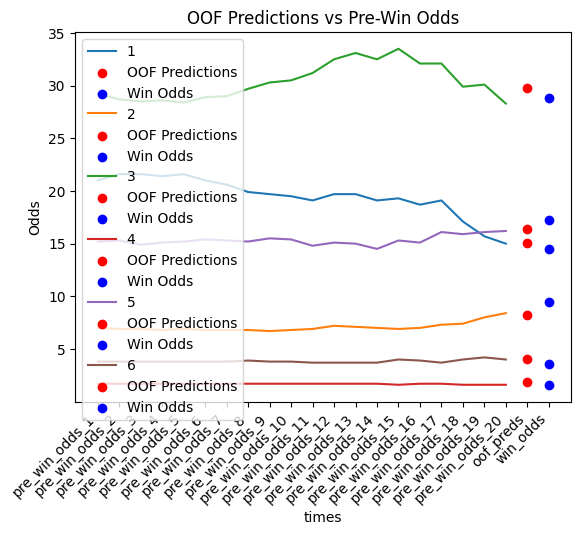

In [236]:
race_data = df4.iloc[:16, :]
race_data = race_data[race_data["win_odds"] < 30]
display(race_data.head())
for i in range(len(race_data)):
    horse_data = race_data.iloc[i, 2:-2]
    plt.plot(horse_data.index, horse_data.values, label=f"{i+1}")
    plt.scatter("oof_preds", race_data.iloc[i,-1], color="red", label="OOF Predictions")
    plt.scatter("win_odds", race_data.iloc[i, -2], color="blue", label="Win Odds")
plt.xticks(rotation=45, ha="right")
plt.legend(loc="upper left") 
plt.title("OOF Predictions vs Pre-Win Odds")
plt.xlabel("times")
plt.ylabel("Odds")